# HomeWork 5

**DeadLine : 12:00 PM 5 Aban 1399**

**Total points : 100 pts**


Import some prerequisites

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Run this cell for plotting

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# PART 4

**Point : 20 pts**

Here is for your helper functions(optional)

Implement this function to detect 45-degree and 135-degree edges in the given image.

In [3]:
def get_45_edges(image):
    '''
    Returns the image which shows the 45-degree edges.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        edges_45 (numpy.ndarray): The 45-degree edges of input image.
    '''
    kernel = None
    edges_45 = image.copy()
    
    #Write your code here
    kernel = np.zeros((3, 3), np.float)
    kernel[0, 0] = -1
    kernel[2, 2] = 1
    edges_45 = cv2.filter2D(edges_45, -1, kernel)
    
    return edges_45

def get_135_edges(image):
    '''
    Returns the image which shows the 135-degree edges.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        edges_135 (numpy.ndarray): The 135-degree edges of input image.
    '''
    kernel = None
    edges_135 = image.copy()
    
    #Write your code here
    kernel = np.zeros((3, 3), np.float)
    kernel[0, 2] = -1
    kernel[2, 0] = 1
    edges_135 = cv2.filter2D(edges_135, -1, kernel)
    
    return edges_135

Test your implementation (dont change this cell)

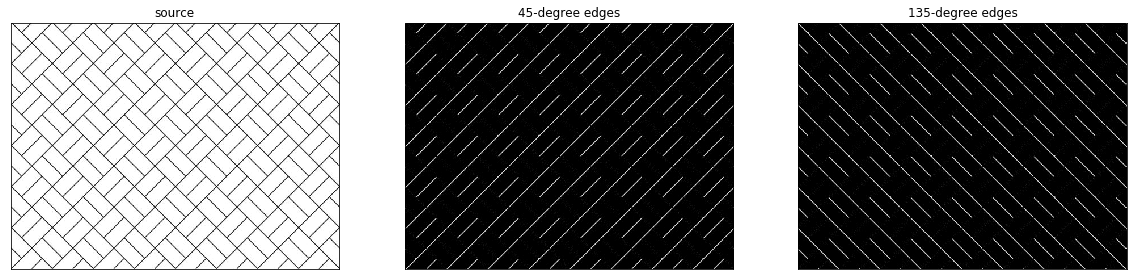

In [4]:
image_list = []

image = cv2.imread(os.path.join('images', '1.jpg'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'source', 'img'])

edges_45 = get_45_edges(image)
edges_135 =get_135_edges(image)

image_list.append([edges_45, '45-degree edges', 'img'])
image_list.append([edges_135, '135-degree edges', 'img'])

plotter(image_list, 1, 3, True, 20, 10, 'Q4')

# PART 5

**Point : 30 pts**

Here is for your helper functions(optional)

In [5]:
def double_threshold(image, low_ratio=0.05, high_ratio=0.1):
    
    high_border = int(image.max() * high_ratio)
    low_border = int(high_border * low_ratio)
    
    rows, cols = image.shape
    double_t = np.zeros((rows,cols), np.float)
    
    for row in range(0, rows):
        for col in range(0, cols):
            if image[row, col] >= high_border:
                double_t[row, col] = 255
            elif image[row, col] < high_border and image[row, col] > low_border:
                double_t[row, col] = 40
    
    return double_t


def isnt_max(pixel, neigh1, neigh2):
    flag = True
    max_ = max([pixel, neigh1, neigh2])
    if pixel == max_ :
        flag = False
    return flag

## Canny Edge Detector
The Canny edge detection algorithm is composed of 4 steps:
1. Smooth image with Gaussian Filter.
2. Find magnitude and orientation of gradient.
3. Apply Non-max suppression.
4. Apply Hysteresis threshold.

### Step 1: Smooth image with Guassian Filter.
Since you will use derivatives calculation in the next step and gradients are highly sensitive to noise, you must first smooth the input image with a Gaussian filter. The equation for a Gaussian kernel is:
\begin{equation*}
G = 
\frac{1}{2 \pi\sigma ^ 2}e^{-\frac{x^2 + y^2}{2\sigma^2}}
\end{equation*}

Implement the below function to calculate Gaussian kernel.

In [6]:
def gaussian_kernel(size, sigma=1):
    '''
    Calculates and Returns Gaussian kernel.

    Parameters:
        size (int): size of kernel.
        sigma(float): standard deviation of gaussian kernel

    Returns:
        gaussian: A 2d array shows gaussian kernel
    '''
    #Writer your code here
    gaussian = None
    rows, cols = size, size
    kernel = np.zeros((rows,cols), np.float)
       
    mid_r = int(rows/2)
    mid_c = int(cols/2)
    std = sigma
    
    k = 1/(2 * np.pi * std * std)
    for i in range(0, rows):
        for j in range(0, cols):
            r = mid_r-i
            s = mid_c-j
            kernel[i, j] = (1 / np.exp((r*r + s*s) / (2 * std * std)))*k
            
    gaussian = kernel
    return gaussian

### Step 2: Find magnitude and orientation of gradient.

The gradient calculation of the image detects the edge magnitude and orientation. So use Sobel kernel in both direction x and y. $K_x$ and $K_y$ are horizontal and vertical Sobel kernels respectively.

$$k_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix} ,
k_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$

Then you must convolve kernels with the image and find the magnitude and orientation of the smooth image.

\begin{equation*}
magnitude = 
\sqrt{I_x^2 + I_y^2}
\end{equation*}

\begin{equation*}
theta(x,y) = arctan(\frac{I_y}{I_x})
\end{equation*}

Implement the below function to find the magnitude and orientation of the image using Sobel kernels.

In [7]:
def sobel_filters(image):
    '''
    finds the magnitude and orientation of the image using Sobel kernels.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        (magnitude, theta): A tuple consists of magnitude and orientation of the image gradients.
    '''
    #Writer your code here
    
    Kx = np.zeros((3,3), np.float)
    Kx[0,0] = -1
    Kx[1,0] = -2
    Kx[2,0] = -1
    Kx[0,2] = 1
    Kx[1,2] = 2
    Kx[2,2] = 1
    
    Ky = np.zeros((3,3), np.float)
    Ky[0,0] = 1
    Ky[0,1] = 2
    Ky[0,2] = 1
    Ky[2,0] = -1
    Ky[2,1] = -2
    Ky[2,2] = -1
    
    Ix = cv2.filter2D(image, cv2.CV_64F, Kx)
    Iy = cv2.filter2D(image, cv2.CV_64F, Ky)
    
    rows, cols = image.shape
    magnitude = np.zeros((rows,cols), np.float)
    theta = np.zeros((rows,cols), np.float)
    
    magnitude = np.sqrt(Ix**2 + Iy**2)
    theta = np.arctan2(Iy, Ix)
    
    return (magnitude, theta)

### Step 3: Non-Maximum Suppression

Ideally, the final image should have thin edges. Thus, we must perform non-maximum suppression to thin the edges. The principle is simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.

Implement the below function to apply Non-Maximum Suppression.

In [8]:
def non_max_suppression(image, theta): 
    '''
    Applies Non-Maximum Suppression.

    Parameters:
        image (numpy.ndarray): The input image.
        theta (numpy.ndarray): The orientation of the image gradients.

    Returns:
        Z(numpy.ndarray): Output of Non-Maximum Suppression algorithm.
    '''
    #Write your code here
    rows, cols = image.shape
    Z = np.zeros((rows,cols), dtype=np.int32)
    
    theta = theta / np.pi * 180

    for row in range(1, rows-1):
        for col in range(1, cols-1):
            
            if (theta[row, col]<0):
                theta[row, col] += 180
                
            value = image[row, col]    
            if theta[row, col] < 22.5 or theta[row, col] >= 157.5:
                result = isnt_max(value, image[row, col-1], image[row, col+1])
                if result:
                    value = 0
            if theta[row, col] >= 22.5 and theta[row, col] < 67.5:
                result = isnt_max(value, image[row+1, col-1], image[row-1, col+1])
                if result:
                    value = 0
            if theta[row, col] >= 67.5 and theta[row, col] < 112.5:
                result = isnt_max(value, image[row-1, col], image[row+1, col])
                if result:
                    value = 0
            if theta[row, col] >= 122.5 and theta[row, col] < 157.5:
                result = isnt_max(value, image[row-1, col-1], image[row+1, col+1])
                if result:
                    value = 0
            Z[row, col] = value
                

    return Z

### Step 4: Apply Hysteresis threshold.

To find strong, weak, and non-relevant pixels, we use a double threshold. A high threshold is used to identify the strong pixels and a low threshold is used to identify the non-relevant pixels. All pixels having intensity between both thresholds are flagged as weak and the Hysteresis mechanism will help you identify the ones that could be considered as strong and the ones that are considered as non-relevant.

Based on the threshold results, the hysteresis transform weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one.

In [9]:
def hysteresis_threshold(image, lowThreshold=60, highThreshold=180):
    '''
    Finds strong, weak, and non-relevant pixels.

    Parameters:
        image (numpy.ndarray): The input image.
        lowThreshold(int): Low Threshold.
        highThreshold(int): High Threshold.
        
    Returns:
        result(numpy.ndarray): Output of applying hysteresis threshold.
    '''
    #Write your code here
    rows, cols = image.shape
    result = np.zeros((rows,cols), dtype=np.int32)
    
    for row in range(1, rows-1):
        for col in range(1, cols-1):
            if (image[row, col] == 40):
                for i in range(row-1, row+2):
                    for j in range(col-1, col+2):
                        if image[i, j] == 255:
                            result[row, col] = 255
            else:
                result[row, col] = image[row, col]

    
    return result

Now put all functions together.

In [10]:
def canny(image, kernel_size = 3, sigma = 1, lowtreshold = 60, hightreshold = 180):
    '''
    Applys Canny edge detector on the input image.

    Parameters:
        image (numpy.ndarray): The input image.
        size (int): size of kernel.
        sigma(float): standard deviation of gaussian kernel.
        lowThreshold(int): Low Threshold.
        highThreshold(int): High Threshold.
        
    Returns:
        img_smoothed(numpy.ndarray): Result of applying the Gaussian kernel on the input image.
        gradient(numpy.ndarray): The image of the gradients.
        nonMaxImg(numpy.ndarray): Output of Non-Maximum Suppression algorithm.
        thresholdImg(numpy.ndarray): Output of applying hysteresis threshold.
        img_final(numpy.ndarray): Result of canny edge detector. The image of detected edges.
    '''
    # Step one, blur using gaussian filter
    working = image.copy()
    kernel = gaussian_kernel(kernel_size, sigma)
    img_smoothed = cv2.filter2D(working, -1, kernel)
    
    # Step two, apply sobel filters and normalize the gradients values
    sobel_tuple = sobel_filters(img_smoothed)
    gradient = sobel_tuple[0]
    theta = sobel_tuple[1]
    
    # Step three, use the gradient angles to supress the non-maximum values
    nonMaxImg = non_max_suppression(gradient, theta)
    
    # Step four, double thresholding (function in the "helper functions" cell)
    thresholdImg = double_threshold(nonMaxImg)
    
    #Step five, hysteresis thresholding:
    img_final = hysteresis_threshold(thresholdImg)
    
    return img_smoothed, gradient, nonMaxImg, thresholdImg, img_final

Test your implementation (dont change this cell)

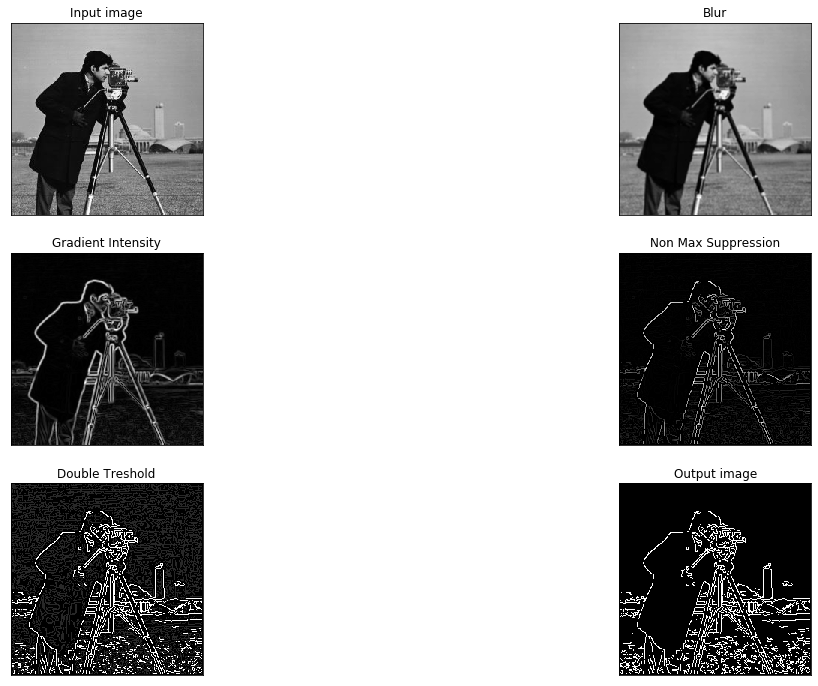

In [11]:
image_list = []
image = cv2.imread(os.path.join('images', '2.jpg'), cv2.IMREAD_GRAYSCALE)
img_smoothed, gradient, nonMaxImg, thresholdImg, img_final = canny(image)

image_list.append([image, 'Input image', 'img'])
image_list.append([img_smoothed, 'Blur', 'img'])
image_list.append([gradient.astype(int),'Gradient Intensity', 'img'])
image_list.append([nonMaxImg, 'Non Max Suppression', 'img'])
image_list.append([thresholdImg, 'Double Treshold', 'img'])
image_list.append([img_final, 'Output image', 'img'])

plotter(image_list, 3, 2, True, 20, 12, 'Q5')

In [13]:
!python notebook_converter.py

End!!!